In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
import plotly

plt.rcParams["figure.figsize"] = (14, 8)
import wrangle

# Acquisition, prep, and split

In [2]:
# Pulling in all data, cleaning and displaying info
aquifer, temps, precip, pop, usage = wrangle.get_dataframes()
aquifer, weather, pop, usage = wrangle.clean_all_dataframes(aquifer, temps, precip, pop, usage)
aquifer.info(), weather.info(), pop.info(), usage.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31919 entries, 1932-11-12 to 2022-06-12
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   water_level_elevation  31919 non-null  float64
dtypes: float64(1)
memory usage: 498.7 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1529 entries, 1895-01-01 to 2022-05-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_monthly_temp      1529 non-null   float64
 1   total_monthly_precip  1529 non-null   float64
dtypes: float64(2)
memory usage: 35.8 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 1850-01-01 to 2022-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   population  38 non-null     int64
dtypes: int64(1)
memory usage: 608.0 bytes
<class 'pandas.core.frame.

(None, None, None, None)

In [3]:
# Setting train size to be 60% of the total dataset
train_size = int(round(aquifer.shape[0] * 0.6))

# set validate size to be 25% of the total dataset
validate_size = int(round(aquifer.shape[0] * 0.25))

# Setting test size to be 15% of the total dataset. 
test_size = int(round(aquifer.shape[0] * 0.15))

In [4]:
# Checking to make sure the split worked
len(aquifer) == train_size + validate_size + test_size

True

In [5]:
validate_end_index = train_size + validate_size
validate_end_index

27131

In [6]:
train = aquifer[:train_size]
validate = aquifer[train_size:validate_end_index]
test = aquifer[validate_end_index:]

In [7]:
# Checking the split to see if the starting and ending values for train, validate and test line up properly.
train.tail(1), validate.head(1), validate.tail(1), test.head(1)

(            water_level_elevation
 date                             
 1987-06-19                 698.85,
             water_level_elevation
 date                             
 1987-06-20                 698.82,
             water_level_elevation
 date                             
 2009-05-03                 659.67,
             water_level_elevation
 date                             
 2009-05-04                 658.37)

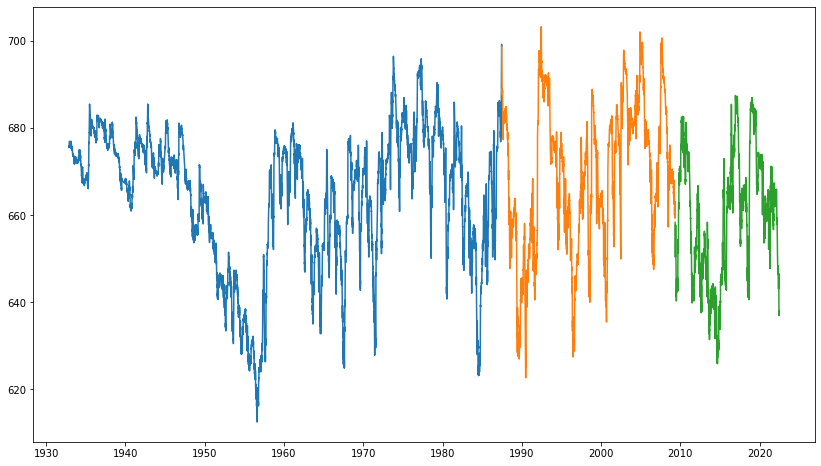

In [8]:
#Plotting out the splits to visualize them
plt.plot(train)
plt.plot(validate)
plt.plot(test)
plt.show()

In [9]:
# Making sure the datasets have accurate frequency data
train = train.asfreq('d', method='bfill')
validate = validate.asfreq('d', method='bfill')
test = test.asfreq('d', method='bfill')

In [10]:
def evaluate(target_var):
    '''
    This function takes in the actual values of the target_var from validate, and the predicted values stored in yhat_df, 
    and computes the rmse, rounding to 0 decimal places. Finally it returns the rmse. 
    '''
    rmse = round((mean_squared_error(validate[target_var], yhat_df[target_var]))**(1/2), 0)
    return rmse

In [11]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [12]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

In [13]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

# Modeling, Forecasting, Predicting

For modeling I will start with some basic predictions in order to acquire a baseline.
1. Last Observed Value: This will predict that future values will look like the most recent value.
2. Simple Average: This will predict that future values will look like a historical average. 
3. Moving Average: This will predict that future values will look like a recent period of time's average. 

Then I will move into more predictive models: 

4. Holt's Linear Trend
5. Previous Cycle

And finally if given time I want to try either:

6. Facebook Prophet
7. LinkedIn Greykite

### Last observed value

The simplest method for forecasting is to predict all future values to be the last observed value.  

In [14]:
# Grabbing the most recent observation in train and assigning it to a variable
last_observed_level = train['water_level_elevation'][-1:][0]
last_observed_level

698.85

In [15]:
yhat_df = pd.DataFrame({'water_level_elevation': [last_observed_level]}, index=validate.index)
yhat_df.head()

,water_level_elevation
date,
1987-06-20,698.85
1987-06-21,698.85
1987-06-22,698.85
1987-06-23,698.85
1987-06-24,698.85


water_level_elevation -- RMSE: 34


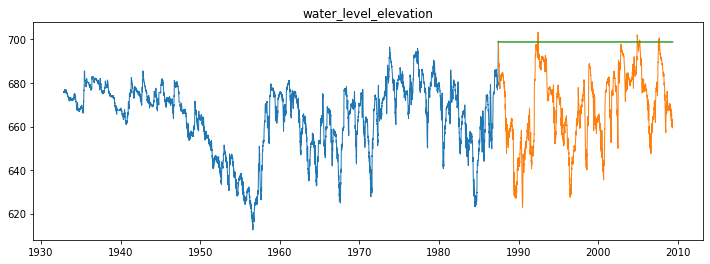

In [16]:
plot_and_eval('water_level_elevation')

In [17]:
eval_df = append_eval_df(model_type = 'last_observed_value', target_var = 'water_level_elevation')
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0


### Simple Average

This takes the historical average and uses that to predict future values.   

This is a possible good option for an initial baseline.

In [18]:
# Computing the historical mean
avg_elevation = round(train['water_level_elevation'].mean(), 2)
avg_elevation

664.44

In [19]:
yhat_df = pd.DataFrame({'water_level_elevation': [avg_elevation]}, index=validate.index)
yhat_df.head()

,water_level_elevation
date,
1987-06-20,664.44
1987-06-21,664.44
1987-06-22,664.44
1987-06-23,664.44
1987-06-24,664.44


water_level_elevation -- RMSE: 18


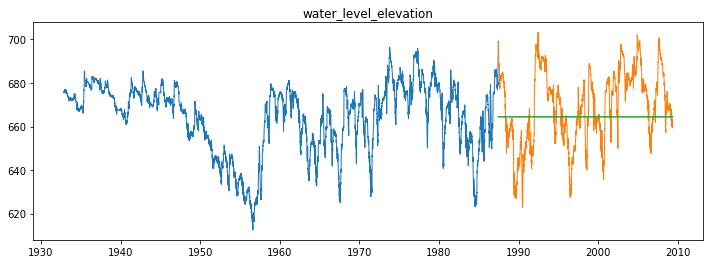

In [20]:
plot_and_eval('water_level_elevation')

In [21]:
eval_df = append_eval_df(model_type = 'avg_elevation', target_var = 'water_level_elevation')
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0
1,avg_elevation,water_level_elevation,18.0


### Moving Average

I will use a range of different rolling averages to see which works the best.

In [22]:
periods = [7, 14, 30, 60, 365, 730, 1825, 3650]

for p in periods: 
    rolling_water_levels = round(train['water_level_elevation'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'water_level_elevation': [rolling_water_levels]},
                          index=validate.index)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)
        

In [23]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0
1,avg_elevation,water_level_elevation,18.0
2,7_day_moving_avg,water_level_elevation,34.0
3,14_day_moving_avg,water_level_elevation,32.0
4,30_day_moving_avg,water_level_elevation,26.0
5,60_day_moving_avg,water_level_elevation,22.0
6,365_day_moving_avg,water_level_elevation,18.0
7,730_day_moving_avg,water_level_elevation,17.0
8,1825_day_moving_avg,water_level_elevation,20.0
9,3650_day_moving_avg,water_level_elevation,17.0


water_level_elevation -- RMSE: 17


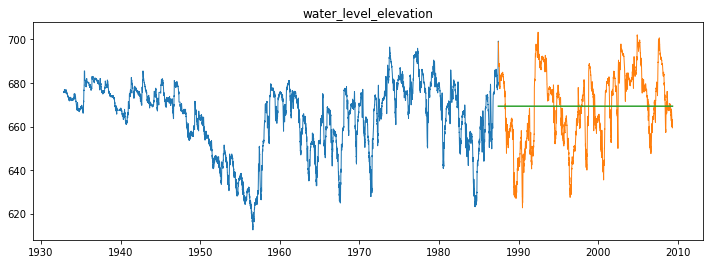

In [24]:
# Visualizing the best of the rolling averages which was the 2 year model.
rolling_water_levels = round(train['water_level_elevation'].rolling(730).mean()[-1], 2)
yhat_df = pd.DataFrame({'water_level_elevation': [rolling_water_levels]},
                          index=validate.index)
plot_and_eval('water_level_elevation')

The best performing model so far is the 730 day (2 year) moving avg with an RMSE of 17 although the overall average isn't farm behind with an RMSE of 18. So going forward the 730_day_moving_avg will be my baseline with RMSE of 17.

### Holt's Linear Trend

For the initial Holt's model I'm going to use base settings and tweak hyperparameters later if needed.

In [25]:
# Creating the initial Holt's Object
model = Holt(train, exponential=False, damped=True)
# Fitting the Holt's object
model = model.fit(optimized=True)
#Making predictions for each date in validate
yhat_items = model.predict(start = validate.index[0], end = validate.index[-1])

/var/folders/r6/g880v64s6vj401drwcc37nf00000gn/T/ipykernel_52227/3369941167.py:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  model = Holt(train, exponential=False, damped=True)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [26]:
# Checking to make sure the length of validate matches the number of predictions given in my yhat_tems
validate.shape, yhat_items

((7989, 1),
 1987-06-20    698.800055
 1987-06-21    698.760099
 1987-06-22    698.728134
 1987-06-23    698.702563
 1987-06-24    698.682105
                  ...    
 2009-04-29    698.600275
 2009-04-30    698.600275
 2009-05-01    698.600275
 2009-05-02    698.600275
 2009-05-03    698.600275
 Freq: D, Length: 7989, dtype: float64)

In [27]:
# add predictions to yhat_df
yhat_df['water_level_elevation'] = pd.DataFrame(yhat_items)

In [28]:
yhat_df

,water_level_elevation
date,
1987-06-20,698.800055
1987-06-21,698.760099
1987-06-22,698.728134
1987-06-23,698.702563
1987-06-24,698.682105
...,...
2009-04-29,698.600275
2009-04-30,698.600275
2009-05-01,698.600275


water_level_elevation -- RMSE: 33


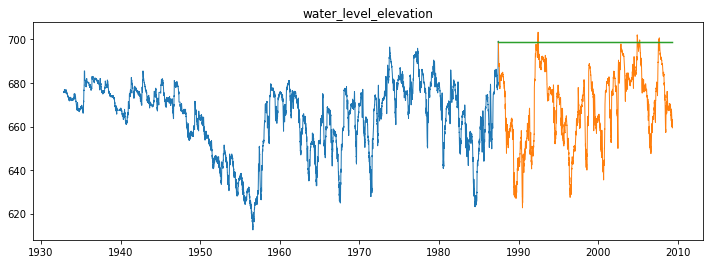

In [29]:
plot_and_eval('water_level_elevation')

In [30]:
eval_df = append_eval_df(model_type = 'holts_optimized', target_var = 'water_level_elevation')
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0
1,avg_elevation,water_level_elevation,18.0
2,7_day_moving_avg,water_level_elevation,34.0
3,14_day_moving_avg,water_level_elevation,32.0
4,30_day_moving_avg,water_level_elevation,26.0
5,60_day_moving_avg,water_level_elevation,22.0
6,365_day_moving_avg,water_level_elevation,18.0
7,730_day_moving_avg,water_level_elevation,17.0
8,1825_day_moving_avg,water_level_elevation,20.0
9,3650_day_moving_avg,water_level_elevation,17.0


Holt's linear trend model performed terribly. Since there is no identifiable previous cycle, I can't use this method to predict future values.

I will need to find a better model if I am going to beat baseline, but it's entirely possible there is no model that will accurately predict this based on water level elevation data alone since it's seemingly random. Thus univariate time series forecasts would not be possible. Taking into account other variable data would be valuable but as it stands this is beyond the scope of this project.

### Facebook Prophet

Attempting to use the prophet model to see if that gives better predictions.

Because Prophet requires specific columns I need to change some names around in order to first use the model.

In [31]:
# Making a new Dataframe appropriate for Prophet to use
train_for_prophet = pd.DataFrame()
train_for_prophet['ds'] = train.index
train_for_prophet['y'] = train.water_level_elevation.values

In [32]:
train_for_prophet['cap'] = train.water_level_elevation.max()
train_for_prophet['floor'] = train.water_level_elevation.min()

In [33]:
# Additional regression column for the model to use later
train['is_rainy'] = (weather.total_monthly_precip > weather.total_monthly_precip.mean()).asfreq('D', method='bfill')
train_for_prophet['is_rainy'] = train.is_rainy

In [34]:
# Checking the new dataframe to confirm it looks appropriate for Prophet
train_for_prophet.head()

,ds,y,cap,floor,is_rainy
0,1932-11-12,675.60,699.23,612.51,NaN
1,1932-11-13,675.82,699.23,612.51,NaN
2,1932-11-14,675.97,699.23,612.51,NaN
3,1932-11-15,675.92,699.23,612.51,NaN
4,1932-11-16,675.74,699.23,612.51,NaN


In [35]:
# Creating the Prophet model
model = Prophet()
# Fitting the model to the train_for_prophet dataframe
model.fit(train_for_prophet)

12:17:18 - cmdstanpy - INFO - Chain [1] start processing
12:17:27 - cmdstanpy - INFO - Chain [1] done processing


In [36]:
# Making the future dataframe to use in the next step for forecasting predictions, the periods parameter here equals
# equals the length of the validate dataframe.
future = model.make_future_dataframe(periods = 7989)
future.tail()

,ds
27927,2009-04-29
27928,2009-04-30
27929,2009-05-01
27930,2009-05-02
27931,2009-05-03


In [37]:
# Confirming that validate and future represent the same time frames.
validate.tail()

,water_level_elevation
date,
2009-04-29,660.24
2009-04-30,660.28
2009-05-01,660.15
2009-05-02,659.83
2009-05-03,659.67


In [38]:
# Forecasting/Predicting into the future of validate
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
27927,2009-04-29,606.905225,-164.266137,1386.338248
27928,2009-04-30,606.866089,-163.540069,1385.419014
27929,2009-05-01,606.860229,-162.384930,1392.730672
27930,2009-05-02,606.930181,-163.314391,1388.857383
27931,2009-05-03,607.109412,-168.620612,1387.503777


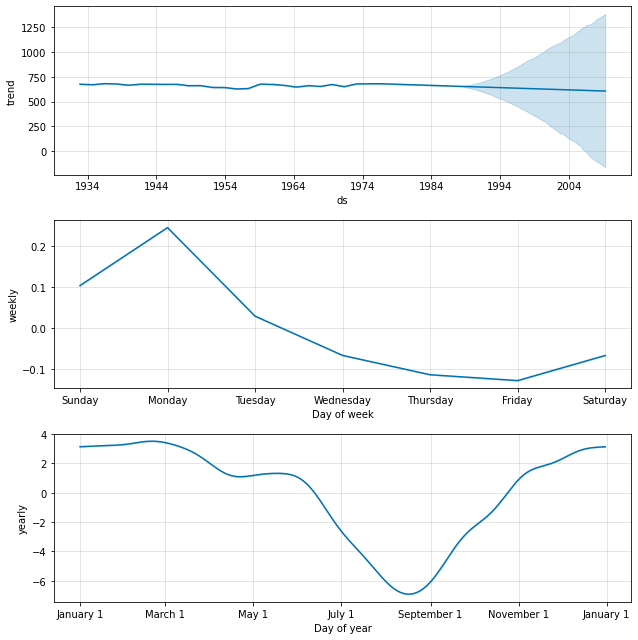

In [39]:
# Plotting out the trend, as well as weekly and yearly seasonality
model.plot_components(forecast)
None

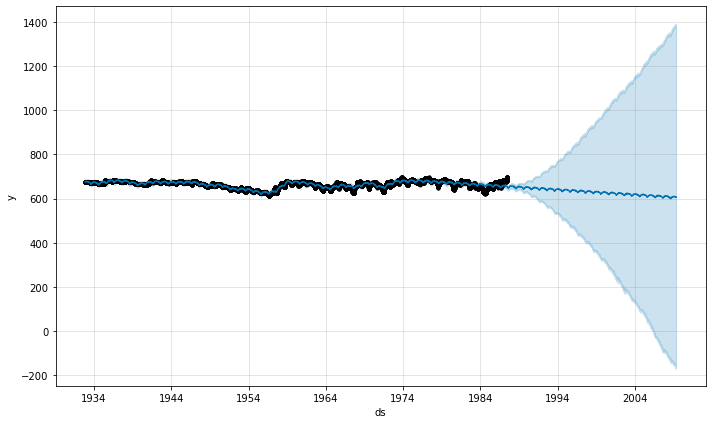

In [40]:
# Plotting out the actual predictions for the validate set from the model.
model.plot(forecast)
None

In [41]:
# putting the predicted values into the yhat_df so I can use the plot and eval function to see RMSE and performance
yhat_df['water_level_elevation'] = forecast.yhat[-7989:].values

In [42]:
# Confirming yhat_df has the correct values
yhat_df

,water_level_elevation
date,
1987-06-20,654.324582
1987-06-21,654.339341
1987-06-22,654.324992
1987-06-23,653.953023
1987-06-24,653.702781
...,...
2009-04-29,606.905225
2009-04-30,606.866089
2009-05-01,606.860229


water_level_elevation -- RMSE: 46


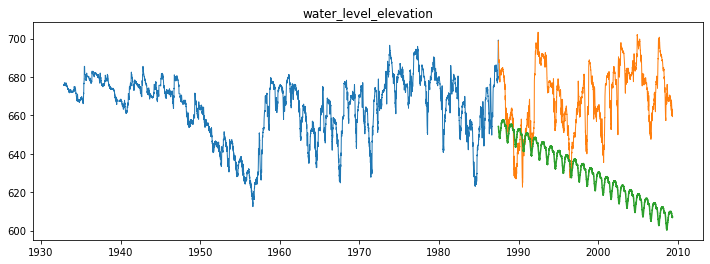

In [43]:
# Running plot_and_eval function to visualize predictions and see RMSE
plot_and_eval('water_level_elevation')

In [44]:
# Adding the Facebook Prophet model to the eval_df 
eval_df = append_eval_df(model_type = 'facebook_prophet', target_var = 'water_level_elevation')
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0
1,avg_elevation,water_level_elevation,18.0
2,7_day_moving_avg,water_level_elevation,34.0
3,14_day_moving_avg,water_level_elevation,32.0
4,30_day_moving_avg,water_level_elevation,26.0
5,60_day_moving_avg,water_level_elevation,22.0
6,365_day_moving_avg,water_level_elevation,18.0
7,730_day_moving_avg,water_level_elevation,17.0
8,1825_day_moving_avg,water_level_elevation,20.0
9,3650_day_moving_avg,water_level_elevation,17.0


The initial Prophet model at default settings performed the worst yet, but I want to tweak some hyperparameters to see if I can improve the model at all.

In [45]:
# The commented out line below creates an interactive plotly graph of the model forecast.
# plot_plotly(model, forecast)

In [46]:
# Tweaking the facebook Prophet model hyperparameters to see if I can find any better results.

# Creating the Prophet model
model = Prophet(growth='flat')
# Fitting the model to the train_for_prophet dataframe
model.fit(train_for_prophet)

# Making the future dataframe to use in the next step for forecasting predictions, the periods parameter here equals
# equals the length of the validate dataframe.
future = model.make_future_dataframe(periods = 7989)

# Forecasting/Predicting into the future of validate
forecast = model.predict(future)
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

12:17:35 - cmdstanpy - INFO - Chain [1] start processing
12:17:35 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
27927,2009-04-29,665.357612,645.521551,685.333592
27928,2009-04-30,665.323403,645.084414,684.457392
27929,2009-05-01,665.322834,645.853731,686.191014
27930,2009-05-02,665.405321,645.832758,687.105970
27931,2009-05-03,665.590526,645.397203,685.065961


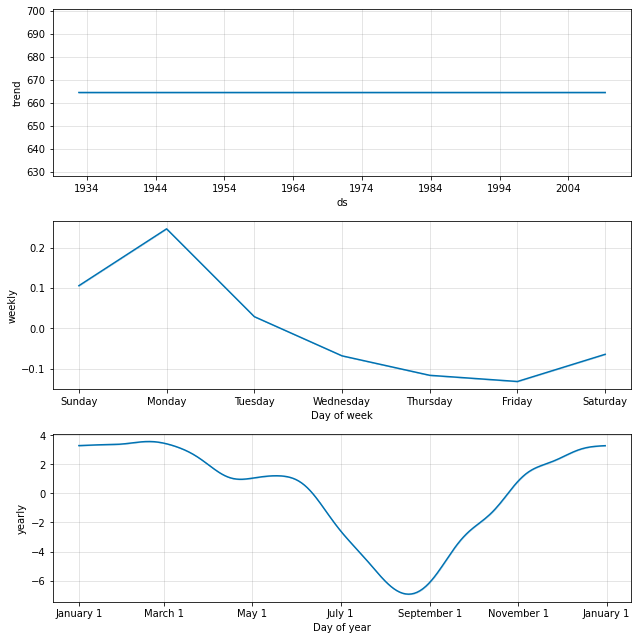

In [47]:
# Plotting out the trend, as well as weekly and yearly seasonality
model.plot_components(forecast)
None

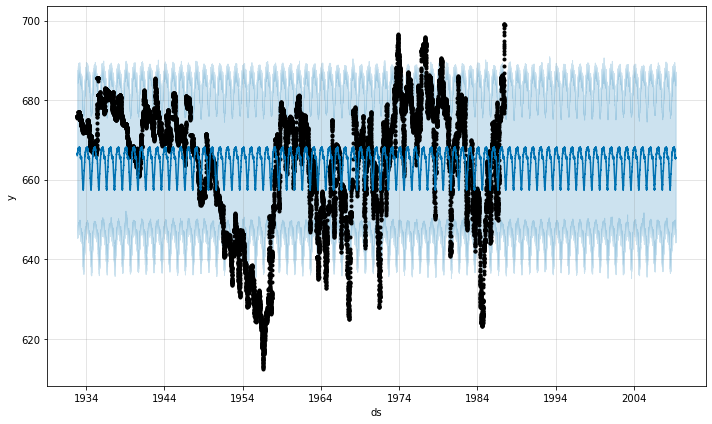

In [48]:
# Plotting out the actual predictions for the validate set from the model.
model.plot(forecast)
None

water_level_elevation -- RMSE: 17


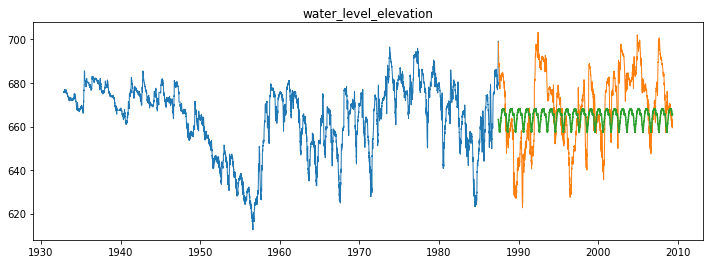

In [49]:
# putting the predicted values into the yhat_df so I can use the plot and eval function to see RMSE and performance
yhat_df['water_level_elevation'] = forecast.yhat[-7989:].values
# Running plot_and_eval function to visualize predictions and see RMSE
plot_and_eval('water_level_elevation')

In [50]:
# Adding the Facebook Prophet model to the eval_df 
eval_df = append_eval_df(model_type = 'facebook_prophet_growth_flat', target_var = 'water_level_elevation')
eval_df

,model_type,target_var,rmse
0,last_observed_value,water_level_elevation,34.0
1,avg_elevation,water_level_elevation,18.0
2,7_day_moving_avg,water_level_elevation,34.0
3,14_day_moving_avg,water_level_elevation,32.0
4,30_day_moving_avg,water_level_elevation,26.0
5,60_day_moving_avg,water_level_elevation,22.0
6,365_day_moving_avg,water_level_elevation,18.0
7,730_day_moving_avg,water_level_elevation,17.0
8,1825_day_moving_avg,water_level_elevation,20.0
9,3650_day_moving_avg,water_level_elevation,17.0


**After tweaking one parameter (growth = 'flat') I improved the prophet model to at least match the RMSE of the baseline average predictor of 17**

In [51]:
# Tweaking the facebook Prophet model hyperparameters to see if I can find any better results.

# Creating the Prophet model
model = Prophet(growth = 'flat', changepoint_prior_scale = 1)
# Fitting the model to the train_for_prophet dataframe
model.fit(train_for_prophet)

# Making the future dataframe to use in the next step for forecasting predictions, the periods parameter here equals
# equals the length of the validate dataframe.
future = model.make_future_dataframe(periods = 7989)

# Forecasting/Predicting into the future of validate
forecast = model.predict(future)

12:17:41 - cmdstanpy - INFO - Chain [1] start processing
12:17:41 - cmdstanpy - INFO - Chain [1] done processing


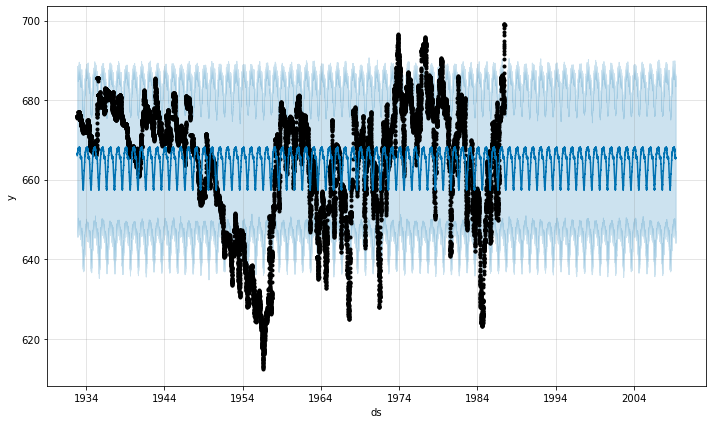

In [52]:
# Plotting out the actual predictions for the validate set from the model.
model.plot(forecast)
None

water_level_elevation -- RMSE: 17


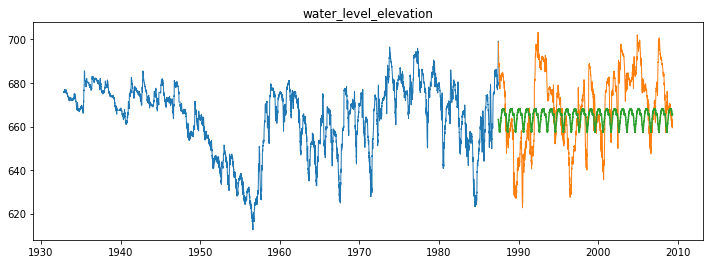

In [53]:
# putting the predicted values into the yhat_df so I can use the plot and eval function to see RMSE and performance
yhat_df['water_level_elevation'] = forecast.yhat[-7989:].values
# Running plot_and_eval function to visualize predictions and see RMSE
plot_and_eval('water_level_elevation')

**Tweaking changepoint_prior_scale didn't seem to have any meaningful effect.**

In [54]:
# Tweaking the facebook Prophet model hyperparameters to see if I can find any better results.

# Creating the Prophet model
model = Prophet(growth = 'flat')
model.add_country_holidays(country_name='US')
# Fitting the model to the train_for_prophet dataframe
model.fit(train_for_prophet)

# Making the future dataframe to use in the next step for forecasting predictions, the periods parameter here equals
# equals the length of the validate dataframe.
future = model.make_future_dataframe(periods = 7989)

# Forecasting/Predicting into the future of validate
forecast = model.predict(future)

12:17:47 - cmdstanpy - INFO - Chain [1] start processing
12:17:47 - cmdstanpy - INFO - Chain [1] done processing


water_level_elevation -- RMSE: 17


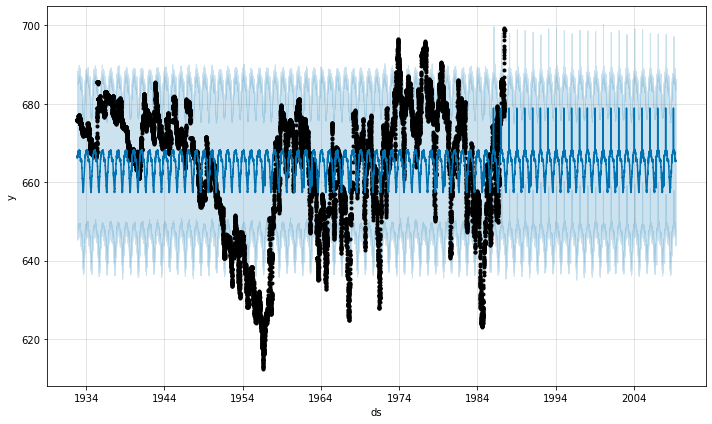

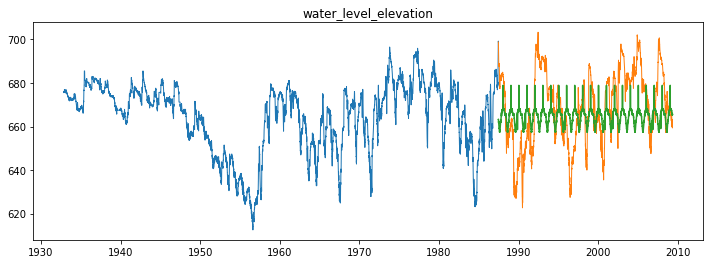

In [55]:
# Plotting out the actual predictions for the validate set from the model.
model.plot(forecast)
None

# putting the predicted values into the yhat_df so I can use the plot and eval function to see RMSE and performance
yhat_df['water_level_elevation'] = forecast.yhat[-7989:].values
# Running plot_and_eval function to visualize predictions and see RMSE
plot_and_eval('water_level_elevation')

**Adding in holiday info didn't seem to have any meaningful effect and the RMSE stayed the same.**

In [56]:
# Tweaking the facebook Prophet model hyperparameters to see if I can find any better results.

# Creating the Prophet model
model = Prophet(growth = 'flat', mcmc_samples=300)

# Fitting the model to the train_for_prophet dataframe
model.fit(train_for_prophet)

# Making the future dataframe to use in the next step for forecasting predictions, the periods parameter here equals
# equals the length of the validate dataframe.
future = model.make_future_dataframe(periods = 7989)


# Forecasting/Predicting into the future of validate
forecast = model.predict(future)

# Plotting out the actual predictions for the validate set from the model.
model.plot(forecast)
None

# putting the predicted values into the yhat_df so I can use the plot and eval function to see RMSE and performance
yhat_df['water_level_elevation'] = forecast.yhat[-7989:].values
# Running plot_and_eval function to visualize predictions and see RMSE
plot_and_eval('water_level_elevation')

12:17:53 - cmdstanpy - INFO - CmdStan installation /opt/homebrew/anaconda3/lib/python3.9/site-packages/prophet/stan_model/cmdstan-2.26.1 missing makefile, cannot get version.
12:17:53 - cmdstanpy - INFO - Cannot determine whether version is before 2.28.
12:17:53 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

12:17:56 - cmdstanpy - ERROR - Chain [4] error: terminated by signal 2 Unknown error: -2
12:17:56 - cmdstanpy - ERROR - Chain [1] error: terminated by signal 2 Unknown error: -2
12:17:56 - cmdstanpy - ERROR - Chain [3] error: terminated by signal 2 Unknown error: -2
12:17:56 - cmdstanpy - ERROR - Chain [2] error: terminated by signal 2 Unknown error: -2


KeyboardInterrupt: 

**Changing mcmc samples didn't seem to have any meaningful effect and the RMSE stayed the same.**

12:18:02 - cmdstanpy - INFO - Chain [1] start processing
12:18:02 - cmdstanpy - INFO - Chain [1] done processing


water_level_elevation -- RMSE: 17


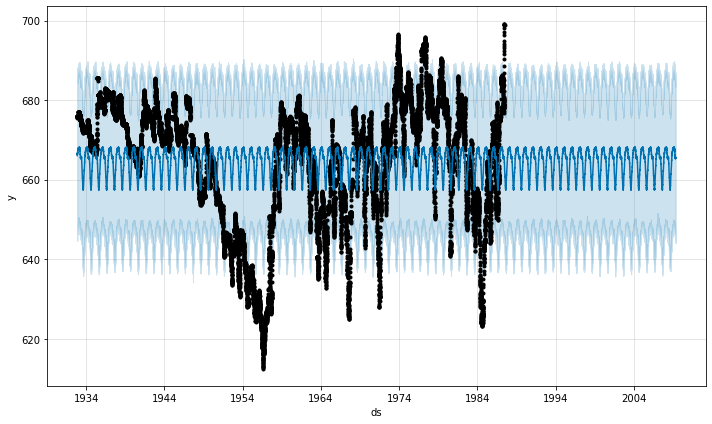

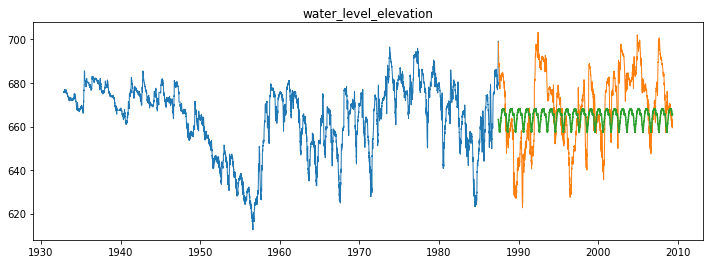

In [57]:
# Tweaking the facebook Prophet model hyperparameters to see if I can find any better results.

# Creating the Prophet model
model = Prophet(growth = 'flat', changepoint_range= .1)

# Fitting the model to the train_for_prophet dataframe
model.fit(train_for_prophet)

# Making the future dataframe to use in the next step for forecasting predictions, the periods parameter here equals
# equals the length of the validate dataframe.
future = model.make_future_dataframe(periods = 7989)


# Forecasting/Predicting into the future of validate
forecast = model.predict(future)

# Plotting out the actual predictions for the validate set from the model.
model.plot(forecast)
None

# putting the predicted values into the yhat_df so I can use the plot and eval function to see RMSE and performance
yhat_df['water_level_elevation'] = forecast.yhat[-7989:].values
# Running plot_and_eval function to visualize predictions and see RMSE
plot_and_eval('water_level_elevation')

**No differences seen when changing changepoint_range.**

After changing values for a number of hyperparameters, the best possible performance was seen with standard paramters and a growth = 'flat'.

I want to come back to try to use grey kite but this will have to be on a future iteration as I'm out of time here.